# OpenGHG for users: accessing and interrogating data

In [1]:
from openghg.objectstore import visualise_store
from openghg.localclient import get_obs_surface
from openghg.processing import search, get_footprint
from openghg.plotting import plot_footprint

%load_ext autoreload
%autoreload 2

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Check measurement data available

We can first check what measurements are currently available within the object store for you to view. 

*Note: not all data will be available for all users to view depending on permissions set*

In [ ]:
visualise_store()

## Accessing the measurement data

You can access the available measurement data using a set of keywords

In [ ]:
site = "bsd" # Site code - BSD is for Bilsdate
species = "co" # Species name - carbon monoxide
inlet = "248m" # Specific inlet height for this site

observations = get_obs_surface(site=site, species=species, inlet=inlet)

The `observations` variable contains both the measurement data and the associated metadata for the data source. The metadata can be viewed:

In [ ]:
observations.metadata

### Tell `matplotlib` we're plotting within a notebook

In [ ]:
%matplotlib inline

The data can be extracted (as an xarray Dataset) and quickly plotted:

In [ ]:
data = observations.data
mol_frac = data.mf
mol_frac.plot()

## Within dates

In [ ]:
site = "hfd"
species = "co2"
inlet = "50m"
start_date = "2017-03-01"
end_date = "2017-03-30"

observations = get_obs_surface(site=site, species=species, inlet=inlet, start_date=start_date, end_date=end_date)

In [ ]:
observations.data

In [ ]:
mol_frac = observations.data.mf
mol_frac.plot()

## Less exact searches

Search for all carbon dioxide measurements in the object store

In [ ]:
results = search(species="co2", skip_ranking=True)

In [ ]:
results

Examine the raw data underneath

In [ ]:
print(results.raw())

In [ ]:
tac_co2 = results.retrieve(species="co2", site="tac", inlet="185m")
data = tac_data.data
data

In [ ]:
mol_frac = data.co2
mol_frac.plot()

In [ ]:
hfd_co2 = results.retrieve(species="co2", site="hfd", inlet="50m")
mol_frac = hfd_co2.data.co2
mol_frac.plot()

### All data from a site

In [ ]:
results = search(site="BSD", skip_ranking=True)

In [ ]:
results

In [ ]:
sf6_data = results.retrieve(species="sf6", site="bsd", inlet="248m")

In [ ]:
mol_frac = sf6_data.data.sf6
mol_frac.plot()

## Comparing to predictions

OpenGHG provides tools which allow calculation of predicted measurements based on emissions sources, where the appropriate data is available.

This is done by aggregrating sensitivity maps (footprints) for a given site and an emissions map covering the same region.

### Retrieve some footprints

Here we retrieve a footprint by itself

In [2]:
footprint = get_footprint(site="TAC", domain="europe", height="185m", start_date="2021-02-01")

In [3]:
fp_data = footprint.data
fp_data

<xarray.Dataset>
Dimensions:               (height: 20, lat: 293, lev: 1, lon: 391, time: 2928)
Coordinates:
  * time                  (time) datetime64[ns] 2021-03-01 ... 2021-06-30T23:...
  * lon                   (lon) float32 -97.9 -97.55 -97.2 ... 38.68 39.03 39.38
  * lat                   (lat) float32 10.73 10.96 11.2 ... 78.59 78.82 79.06
  * lev                   (lev) |S1 b'F'
  * height                (height) float32 500.0 1.5e+03 ... 1.85e+04 1.95e+04
Data variables: (12/16)
    fp                    (lat, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    temperature           (time) float32 4.111 1.718 1.45 ... 11.26 11.23 11.06
    pressure              (time) float32 1.005e+03 1.005e+03 ... 989.1 989.2
    wind_speed            (time) float32 7.452 5.937 6.039 ... 6.225 6.509 7.433
    wind_direction        (time) float32 90.01 81.59 84.1 ... 335.0 322.0 318.1
    PBLH                  (time) float32 94.57 215.1 222.3 ... 257.9 240.3 307.7
    ...                    ...
    particle_locations_s  (height, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    particle_locations_w  (height, lat, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    mean_age_particles_n  (height, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    mean_age_particles_e  (height, lat, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    mean_age_particles_s  (height, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    mean_age_particles_w  (height, lat, time) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/16)
    author:           OpenGHG Cloud
    processed:        2021-08-13 11:16:58.801900+00:00
    data_type:        footprint
    site:             tac
    height:           185m
    domain:           europe
    ...               ...
    min_longitude:    -97.9
    max_latitude:     79.057
    min_latitude:     10.729
    time_resolution:  standard_time_resolution
    heights:          [  500.  1500.  2500.  3500.  4500.  5500.  6500.  7500...
    variables:        ['fp', 'temperature', 'pressure', 'wind_speed', 'wind_d...

### Plot the footprint

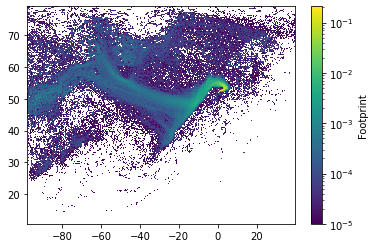

In [4]:
plot_footprint(data=fp_data, label="Footprint")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, ax = plt.subplots()

## Plot footprints as a 2D colour map
data_fp = fp_data.fp.isel(time=0) # First time point
lat = data_fp.lat
lon = data_fp.lon
footprint = data_fp.values

vmin = 1e-5 # min is 0 and can't use 0 for a log scale
vmax = footprint.max()

im = ax.pcolormesh(lon, lat, footprint, 
              norm=colors.LogNorm(vmin=vmin, 
                                  vmax=vmax), shading="auto") # Put on a log scale
cb = plt.colorbar(im, ax=ax)
cb.set_label("Footprint")

## Add station position
attrs = fp_data.attrs
if "station_longitude" in attrs and "station_latitude" in attrs:
    station_lon = data.attrs["station_longitude"]
    station_lat = data.attrs["station_latitude"]
    ax.scatter([station_lon],[station_lat])
    
print(attrs)

## Viewing emissions data

Any emissions data itself can be viewed through OpenGHG...

**++ADD PLOTS OF EMISSIONS HERE++**

*May have an issue that we want to be able to plot this on a map, in which case we would need a working link to cartopy and proj C library. Need to decide if we want this to be a dependency of openghg or not or perhaps incorporate openghg-plotting library instead*